In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import pandas as pd
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import copy

In [2]:
class ResizeKeepAspectPad:
    def __init__(self, target_size=224):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        # Compute scale factor to fit max dimension
        scale = self.target_size / max(h, w)
        new_w, new_h = int(w*scale), int(h*scale)
        img = img.resize((new_w, new_h), Image.BILINEAR)

        # Compute padding for each side
        pad_left = (self.target_size - new_w) // 2
        pad_right = self.target_size - new_w - pad_left
        pad_top = (self.target_size - new_h) // 2
        pad_bottom = self.target_size - new_h - pad_top

        img = TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)
        return img

In [3]:
class ZPinchDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, y_mean=None, y_std=None, mode="ALL"):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        self.y_mean = y_mean
        self.y_std = y_std

        # Build image map
        self.image_map = {}
        for fname in os.listdir(img_dir):
            name, ext = os.path.splitext(fname)
            self.image_map[name] = os.path.join(img_dir, fname)

        self.labels_df['image_path'] = self.labels_df['image_name'].apply(
            lambda x: self.image_map.get(x)
        )
        self.labels_df = self.labels_df.dropna(subset=['image_path']).reset_index(drop=True)

        # 🔹 FILTER BY DIAGNOSTIC
        if mode == "SCH":
            self.labels_df = self.labels_df[
                self.labels_df['image_name'].str.contains("SCH")
            ]
        elif mode == "MCP":
            self.labels_df = self.labels_df[
                self.labels_df['image_name'].str.contains("MCP")
            ]

        self.labels_df = self.labels_df.reset_index(drop=True)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]

        image = Image.open(row['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = torch.tensor([
            row['radius_norm'],
            row['mrti_amplitude_norm'],
            row.get('angle_norm', row.get('avg_angle', 0))
        ], dtype=torch.float32)

        # 🔹 NORMALIZE LABELS HERE
        if self.y_mean is not None:
            labels = (labels - self.y_mean) / self.y_std

        return image, labels


In [4]:
class ZPinchResNet(nn.Module):
    def __init__(self, num_outputs=3, use_extra_input=False):
        super().__init__()
        self.use_extra_input = use_extra_input

        # Pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Remove original fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # keep features

        # Optional extra input (like pinch_height)
        if use_extra_input:
            self.fc = nn.Sequential(
                nn.Linear(num_features + 1, 128),
                nn.ReLU(),
                nn.Linear(128, num_outputs)
            )
        else:
            self.fc = nn.Linear(num_features, num_outputs)

    def forward(self, x, extra_input=None):
        features = self.resnet(x)
        if self.use_extra_input and extra_input is not None:
            features = torch.cat([features, extra_input.unsqueeze(1)], dim=1)
        out = self.fc(features)
        return out


In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        """
        patience  : number of epochs with no improvement before stopping
        min_delta : minimum change to qualify as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


In [6]:
# Example transforms for ResNet
base_transform = transforms.Compose([
    ResizeKeepAspectPad(target_size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_transform = transforms.Compose([
    ResizeKeepAspectPad(224),

    transforms.Grayscale(num_output_channels=3),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=0.5),

    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1
    ),

    transforms.ToTensor(),

    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
# First dataset WITHOUT normalization
dataset = ZPinchDataset(
    'nn_training_labels_normalized.csv',
    'images',
    transform=base_transform,
    mode="ALL"
)

val_fraction = 0.2
n_val = int(len(dataset) * val_fraction)
n_train = len(dataset) - n_val

train_indices, val_indices = random_split(
    range(len(dataset)), [n_train, n_val]
)

# 🔹 Compute mean/std on TRAINING LABELS ONLY
all_train_labels = []
for idx in train_indices:
    _, lbl = dataset[idx]
    all_train_labels.append(lbl)

all_train_labels = torch.stack(all_train_labels)

y_mean = all_train_labels.mean(dim=0)
y_std  = all_train_labels.std(dim=0)
y_std[y_std == 0] = 1.0  # safety

print("Label mean:", y_mean)
print("Label std :", y_std)

# 🔹 Recreate datasets WITH normalization
train_dataset = ZPinchDataset(
    'nn_training_labels_normalized.csv',
    'images',
    transform=train_transform,
    y_mean=y_mean,
    y_std=y_std,
    mode="ALL"
)

val_dataset = ZPinchDataset(
    'nn_training_labels_normalized.csv',
    'images',
    transform=base_transform,
    y_mean=y_mean,
    y_std=y_std,
    mode="ALL"
)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset   = torch.utils.data.Subset(val_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Total images      : {len(dataset)}")
print(f"Training images : {len(train_dataset)}")
print(f"Validation images : {len(val_dataset)}")

Label mean: tensor([0.3822, 0.0596, 7.4190])
Label std : tensor([0.1850, 0.0287, 5.7314])
Total images      : 701
Training images : 561
Validation images : 140


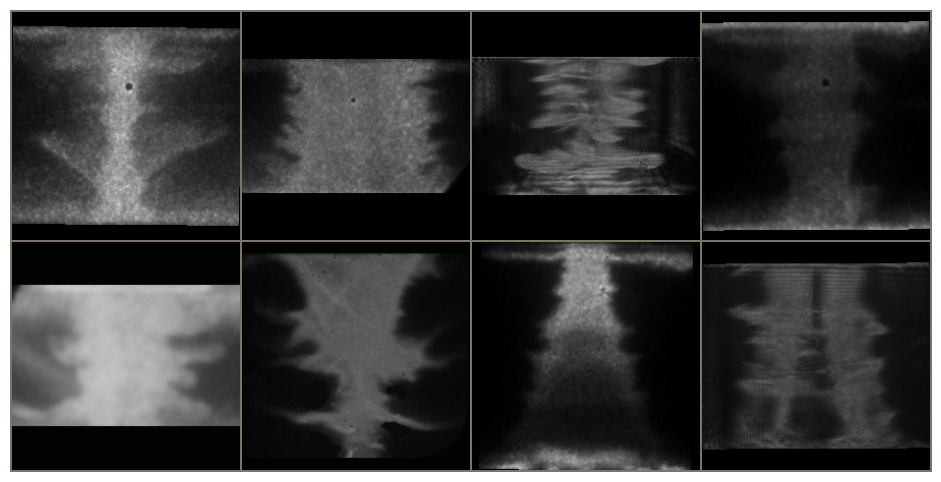

Image 0: radius_norm=-0.994, mrti_norm=0.478, angle=-0.58
Image 1: radius_norm=0.887, mrti_norm=-0.449, angle=0.16
Image 2: radius_norm=-0.405, mrti_norm=1.379, angle=-0.84
Image 3: radius_norm=-1.086, mrti_norm=-0.857, angle=-0.81
Image 4: radius_norm=0.096, mrti_norm=-0.384, angle=-0.62
Image 5: radius_norm=-0.862, mrti_norm=0.192, angle=0.77
Image 6: radius_norm=-1.085, mrti_norm=-1.483, angle=0.33
Image 7: radius_norm=-0.138, mrti_norm=-0.888, angle=0.17


In [8]:
# Get a batch of 8 images
batch_size = 8
batch = [train_dataset[i] for i in range(batch_size)]
images, labels = zip(*batch)

# Convert to a single tensor batch for torchvision
images_tensor = torch.stack(images)

# Make a grid
grid = torchvision.utils.make_grid(images_tensor, nrow=4)
grid = grid.permute(1, 2, 0).numpy()  # CHW -> HWC

# Undo normalization for display
grid = grid * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
grid = grid.clip(0, 1)

plt.figure(figsize=(12,6))
plt.imshow(grid)
plt.axis('off')
plt.show()

# Print labels for reference
for i, lbl in enumerate(labels):
    print(f"Image {i}: radius_norm={lbl[0]:.3f}, mrti_norm={lbl[1]:.3f}, angle={lbl[2]:.2f}")


In [9]:
model = ZPinchResNet(num_outputs=3, use_extra_input=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.resnet.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


/Users/orenyang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/orenyang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
num_epochs_phase1 = 100

train_losses_p1 = []
val_losses_p1   = []

early_stopper = EarlyStopping(
    patience=5,      
    min_delta=1e-4
)

best_state = None

for epoch in range(num_epochs_phase1):
    # -------- TRAIN --------
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses_p1.append(train_loss)

    # -------- VALIDATE --------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses_p1.append(val_loss)

    if val_loss < early_stopper.best_loss:
        best_state = copy.deepcopy(model.state_dict())

    early_stopper.step(val_loss)

    print(
        f"[P1] Epoch {epoch+1}: "
        f"Train = {train_loss:.4f}, Val = {val_loss:.4f}"
    )

    if early_stopper.should_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(best_state)

for p in model.resnet.layer3.parameters():
    p.requires_grad = True
for p in model.resnet.layer4.parameters():
    p.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5
)

num_epochs_phase2 = 100

train_losses_p2 = []
val_losses_p2   = []

early_stopper = EarlyStopping(
    patience=5,      
    min_delta=5e-5
)

for epoch in range(num_epochs_phase2):
    # -------- TRAIN --------
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses_p2.append(train_loss)

    # -------- VALIDATE --------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses_p2.append(val_loss)

    if val_loss < early_stopper.best_loss:
        best_state = copy.deepcopy(model.state_dict())

    early_stopper.step(val_loss)

    print(
        f"[P2] Epoch {epoch+1}: "
        f"Train = {train_loss:.4f}, Val = {val_loss:.4f}"
    )

    if early_stopper.should_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(best_state)


[P1] Epoch 1: Train = 1.0113, Val = 0.9747
[P1] Epoch 2: Train = 0.8183, Val = 0.8751
[P1] Epoch 3: Train = 0.7293, Val = 0.6906
[P1] Epoch 4: Train = 0.6551, Val = 0.6959
[P1] Epoch 5: Train = 0.6527, Val = 0.6856
[P1] Epoch 6: Train = 0.6176, Val = 0.6052
[P1] Epoch 7: Train = 0.5792, Val = 0.5868
[P1] Epoch 8: Train = 0.5575, Val = 0.6417
[P1] Epoch 9: Train = 0.5595, Val = 0.6081
[P1] Epoch 10: Train = 0.5442, Val = 0.5518
[P1] Epoch 11: Train = 0.5376, Val = 0.5471
[P1] Epoch 12: Train = 0.5317, Val = 0.5522
[P1] Epoch 13: Train = 0.5493, Val = 0.5422
[P1] Epoch 14: Train = 0.5444, Val = 0.5328
[P1] Epoch 15: Train = 0.5482, Val = 0.5612
[P1] Epoch 16: Train = 0.5439, Val = 0.5446
[P1] Epoch 17: Train = 0.5082, Val = 0.5823
[P1] Epoch 18: Train = 0.5312, Val = 0.5403
[P1] Epoch 19: Train = 0.5144, Val = 0.5977
Early stopping triggered at epoch 19
[P2] Epoch 1: Train = 0.4990, Val = 0.4749
[P2] Epoch 2: Train = 0.3602, Val = 0.4184
[P2] Epoch 3: Train = 0.3132, Val = 0.3897
[P2] Ep

<All keys matched successfully>

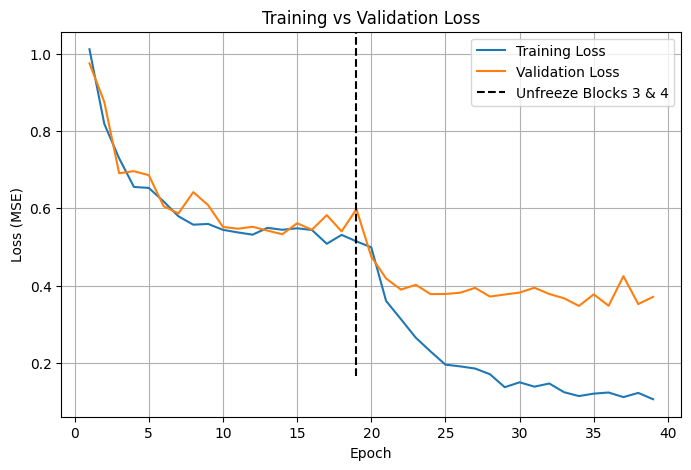

In [11]:
# Combine phase 1 and phase 2 losses
train_losses = train_losses_p1 + train_losses_p2
val_losses   = val_losses_p1   + val_losses_p2

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.axvline(len(train_losses_p1),min(train_losses),max(train_losses),color='black',linestyle='--', label='Unfreeze Blocks 3 & 4')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


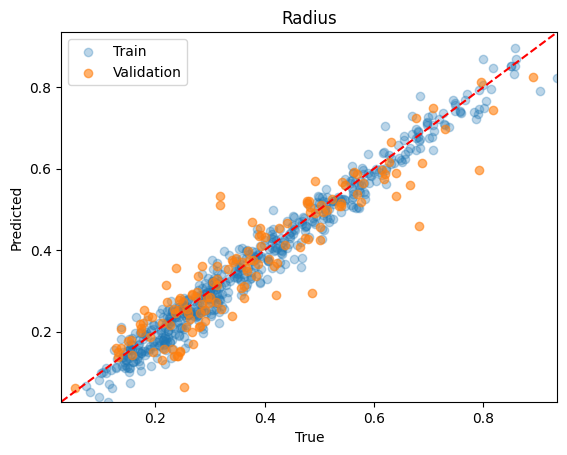

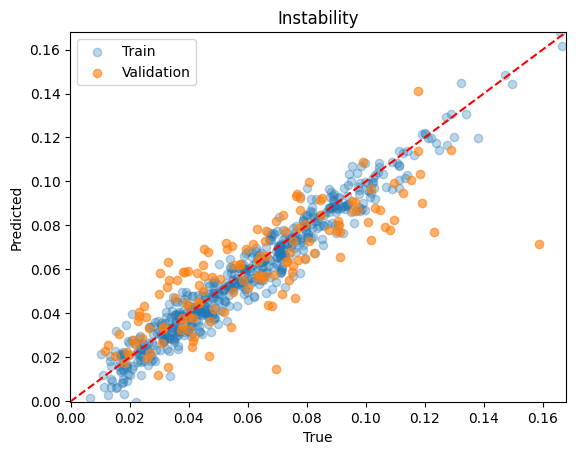

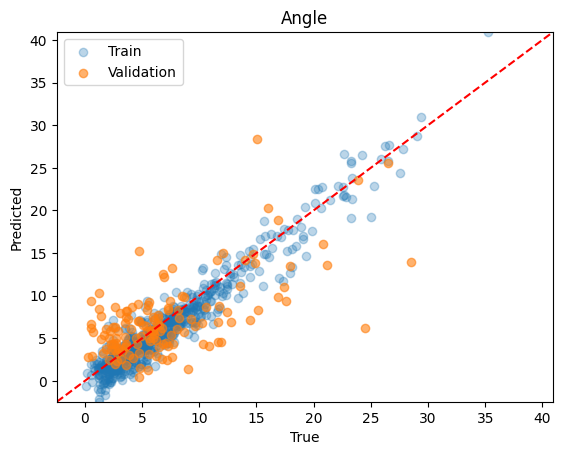

In [12]:
train_labels = []
train_preds = []

model.eval()
with torch.no_grad():
    for img, label in train_loader:
        img = img.to(device)

        label = label.numpy() * y_std.numpy() + y_mean.numpy()
        pred_norm = model(img).cpu()
        pred = pred_norm * y_std + y_mean
        pred = pred.numpy()

        train_labels.append(label)
        train_preds.append(pred)

train_labels = np.concatenate(train_labels)
train_preds  = np.concatenate(train_preds)


val_labels = []
val_preds = []

model.eval()
with torch.no_grad():
    for img, label in val_loader:
        img = img.to(device)
        label = label.numpy() * y_std.numpy() + y_mean.numpy()
        pred_norm = model(img).cpu()
        pred = pred_norm * y_std + y_mean
        pred = pred.numpy()
        val_labels.append(label)
        val_preds.append(pred)


val_labels = np.concatenate(val_labels)
val_preds = np.concatenate(val_preds)

for i, name in enumerate(["Radius", "Instability", "Angle"]):
    plt.figure()

    plt.scatter(
        train_labels[:, i], train_preds[:, i],
        alpha=0.3, label="Train"
    )
    plt.scatter(
        val_labels[:, i], val_preds[:, i],
        alpha=0.6, label="Validation"
    )

    vmin = min(
        train_labels[:, i].min(),
        val_labels[:, i].min(),
        train_preds[:, i].min(),
        val_preds[:, i].min()
    )
    vmax = max(
        train_labels[:, i].max(),
        val_labels[:, i].max(),
        train_preds[:, i].max(),
        val_preds[:, i].max()
    )

    plt.plot([vmin, vmax], [vmin, vmax], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(name)
    plt.legend()
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    plt.show()


In [ ]:
torch.save(model.state_dict(), "zpinch_resnet.pth")


In [ ]:
model = ZPinchResNet(num_outputs=3)
model.load_state_dict(torch.load("zpinch_resnet.pth"))
model.eval()  # set to evaluation mode
